In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from zipfile import ZipFile
zip = ZipFile('/content/drive/MyDrive/Tech_seminar/Data.zip')
zip.extractall()

In [3]:
from zipfile import ZipFile
zip = ZipFile('/content/drive/MyDrive/Tech_seminar/test.zip')
zip.extractall()

In [ ]:
pip uninstall tensorflow

In [ ]:
pip install tensorflow

In [ ]:
pip install 'h5py==2.10.0' --force-reinstall

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import History
# from tensorflow.contrib.tpu.python.tpu import keras_support
import tensorflow.keras.backend as K

# from ricap import ricap
import os, pickle

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
import os, pickle
from tensorflow.keras.callbacks import History

In [6]:
img_width, img_height = 128, 128

train_data_dir = '/content/Data/Train'
validation_data_dir = '/content/Data/Validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16


In [7]:
class RICAPGenerator(ImageDataGenerator):
    def __init__(self, ricap_beta=0.3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ricap_beta = ricap_beta

    def flow_from_directory(self, *args, **kwargs):
        for batch_X, batch_y in super().flow_from_directory(*args, **kwargs):
            ricap_X, ricap_y = ricap(batch_X, batch_y, self.ricap_beta)
            yield ricap_X, ricap_y

In [ ]:
# def create_network():
#     net = DenseNet121(include_top=False, weights="imagenet", input_shape=(128,128,3))

#     # don't train until conv4 blocks
#     for l in net.layers:
#         if "conv4" in l.name: break
#         l.trainable = False

#     x = GlobalAveragePooling2D()(net.layers[-1].output)
#     x = Dense(2, activation="softmax")(x)

#     return Model(net.inputs, x)

In [8]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [9]:
def create_network():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(128))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2))
  model.add(Activation('sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])
  return model

In [10]:
def ricap(image_batch, label_batch, beta=0.3, use_same_random_value_on_batch=True):
    # if use_same_random_value_on_batch = True : same as the original paper
    assert image_batch.shape[0] == label_batch.shape[0]
    assert image_batch.ndim == 4
    batch_size, image_y, image_x = image_batch.shape[:3]

    # crop_size w, h from beta distribution
    if use_same_random_value_on_batch:
        w_dash = np.random.beta(beta, beta) * np.ones(batch_size)
        h_dash = np.random.beta(beta, beta) * np.ones(batch_size)
    else:
        w_dash = np.random.beta(beta, beta, size=(batch_size))
        h_dash = np.random.beta(beta, beta, size=(batch_size))
    w = np.round(w_dash * image_x).astype(np.int32)
    h = np.round(h_dash * image_y).astype(np.int32)

    # outputs
    output_images = np.zeros(image_batch.shape)
    output_labels = np.zeros(label_batch.shape)


    def create_masks(start_xs, start_ys, end_xs, end_ys):
        mask_x = np.logical_and(np.arange(image_x).reshape(1,1,-1,1) >= start_xs.reshape(-1,1,1,1), 
                                np.arange(image_x).reshape(1,1,-1,1) < end_xs.reshape(-1,1,1,1))
        mask_y = np.logical_and(np.arange(image_y).reshape(1,-1,1,1) >= start_ys.reshape(-1,1,1,1),
                                np.arange(image_y).reshape(1,-1,1,1) < end_ys.reshape(-1,1,1,1))
        mask = np.logical_and(mask_y, mask_x)
        mask = np.logical_and(mask, np.repeat(True, image_batch.shape[3]).reshape(1,1,1,-1))
        return mask

    def crop_concatenate(wk, hk, start_x, start_y, end_x, end_y):
        nonlocal output_images, output_labels
        xk = (np.random.rand(batch_size) * (image_x-wk)).astype(np.int32)
        yk = (np.random.rand(batch_size) * (image_y-hk)).astype(np.int32)
        target_indices = np.arange(batch_size)
        np.random.shuffle(target_indices)
        weights = wk * hk / image_x / image_y

        dest_mask = create_masks(start_x, start_y, end_x, end_y)
        target_mask = create_masks(xk, yk, xk+wk, yk+hk)

        output_images[dest_mask] = image_batch[target_indices][target_mask]
        output_labels += weights.reshape(-1, 1) * label_batch[target_indices]

    # left-top crop
    crop_concatenate(w, h, 
                     np.repeat(0, batch_size), np.repeat(0, batch_size), 
                     w, h)
    # right-top crop
    crop_concatenate(image_x-w, h, 
                     w, np.repeat(0, batch_size), 
                     np.repeat(image_x, batch_size), h)
    # left-bottom crop
    crop_concatenate(w, image_y-h, 
                     np.repeat(0, batch_size), h, 
                     w, np.repeat(image_y, batch_size))
    # right-bottom crop
    crop_concatenate(image_x-w, image_y-h, 
                     w, h, np.repeat(image_x, batch_size), 
                     np.repeat(image_y, batch_size))

    return output_images, output_labels

In [11]:
import numpy as np

In [12]:
train_gen_instance = RICAPGenerator(rescale=1.0/255, width_shift_range=15.0/128, 
                                            height_shift_range=15.0/128, horizontal_flip=True, ricap_beta=0.3)
train_gen = train_gen_instance.flow_from_directory(
    train_data_dir, target_size=(128,128), batch_size=batch_size)
test_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    validation_data_dir, target_size=(128,128), batch_size=batch_size)

model = create_network()
# model.compile(tf.train.RMSPropOptimizer(1e-4), "categorical_crossentropy", ["acc"])
# model.compile(loss='categorical_crossentropy',
#                 optimizer='rmsprop',
#                 metrics=['accuracy'])

# tpu_grpc_url = "grpc://"+os.environ["COLAB_TPU_ADDR"]
# tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
# strategy = keras_support.TPUDistributionStrategy(tpu_cluster_resolver)
# model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

# hist = History()
# history1 = model.fit_generator(train_gen, steps_per_epoch=10062//batch_size, callbacks=[hist],
#                     validation_data=test_gen, validation_steps=4428//batch_size, epochs=25)

# history = hist.history
# with open(f"anime_ricap_{use_ricap}.dat", "wb") as fp:
#     pickle.dump(history, fp)

Found 800 images belonging to 2 classes.


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
hist = History()
model_checkpoint = ModelCheckpoint("ricap.model", verbose=1 , save_best_only=True)
history1 = model.fit(train_gen, steps_per_epoch=2000//16, callbacks=[hist, model_checkpoint],
                    validation_data=test_gen, validation_steps=800//16, epochs=1000)

history = hist.history


Found 2000 images belonging to 2 classes.
Epoch 1/1000
125/125 [==============================] - 61s 140ms/step - loss: 0.7656 - accuracy: 0.4805 - val_loss: 0.6927 - val_accuracy: 0.5700

Epoch 00001: val_loss improved from inf to 0.69274, saving model to ricap.model
INFO:tensorflow:Assets written to: ricap.model/assets
Epoch 2/1000
125/125 [==============================] - 17s 136ms/step - loss: 0.6940 - accuracy: 0.5032 - val_loss: 0.6876 - val_accuracy: 0.6000

Epoch 00002: val_loss improved from 0.69274 to 0.68759, saving model to ricap.model
INFO:tensorflow:Assets written to: ricap.model/assets
Epoch 3/1000
125/125 [==============================] - 17s 137ms/step - loss: 0.6937 - accuracy: 0.5356 - val_loss: 0.6725 - val_accuracy: 0.6237

Epoch 00003: val_loss improved from 0.68759 to 0.67251, saving model to ricap.model
INFO:tensorflow:Assets written to: ricap.model/assets
Epoch 4/1000
125/125 [==============================] - 17s 137ms/step - loss: 0.6893 - accuracy: 0.5441


Epoch 465/1000
125/125 [==============================] - 18s 142ms/step - loss: 0.5458 - accuracy: 0.8006 - val_loss: 0.3126 - val_accuracy: 0.8875

Epoch 00465: val_loss improved from 0.33516 to 0.31255, saving model to ricap.model

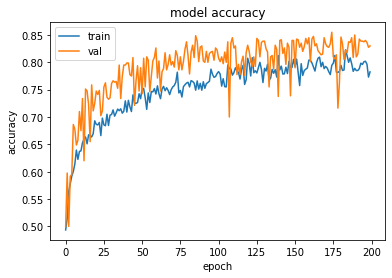

In [15]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

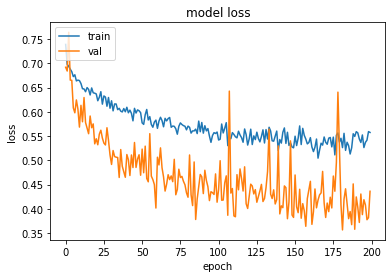

In [16]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('/content/data_augment.model')
# predicted_score = model1.predict(testX)
# score = model1.evaluate(testX, testY)
# print("test loss, test acc:", score)

In [ ]:
import os
import cv2
import numpy as np
test = []
for filename in os.listdir('/content/test'):
    img = cv2.imread('/content/test/' + filename, cv2.IMREAD_COLOR)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGB_img = cv2.resize(RGB_img, (160, 160), cv2.INTER_AREA)
    test.append(RGB_img)
    test.append(RGB_img)


In [ ]:
test = np.array(test)
test = test.astype('float32') / 255.0

[[0.00406126 0.9959388 ]]


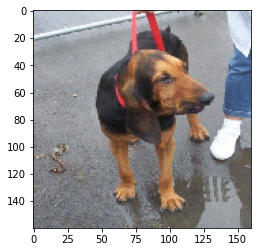

In [ ]:
import matplotlib.pyplot as plt
n = 3
img1 = (test[n] * 255).astype(np.uint8)
img1 = img1.reshape(160,160,3)
plt.imshow(img1)
# img = np.expand_dims(trainx[1], axis=0)
# img = img.astype('float32')
# img = testx[0].reshape(1,testx[0].shape)
img = test[n].reshape(1, 160, 160, 3)
x = model.predict(img)
print(x)
# print(testY[n])